# Machine Learning Engineer Nanodegree
## Capstone Project
Michel Moreau  
August 5th, 2019

## I. Definition
_(approx. 1-2 pages)_

### Project Overview
[**CellSignal** - _Disentangling biological signal from experimental noise in cellular images_](https://www.rxrx.ai/)

#### Introduction
My final project is to participale in the NeurIPS competition on Kaggle called **CellSignal** - _Disentangling biological signal from experimental noise in cellular images_. More information about this competition is available here:  
- Competition's website https://www.rxrx.ai  
- Kaggle competition's link: https://www.kaggle.com/c/recursion-cellular-image-classification/overview


#### Domain Background  
Recursion Pharmaceuticals, creators of the industry’s largest dataset of biological images, generated entirely in-house, believes AI has the potential to dramatically improve and expedite the drug discovery process. More specifically, machine learning could help understand how drugs interact with human cells.

This competition is designed to disentangle experimental noise from real biological signals. The goal is to classify images of cells under one of 1,108 different genetic perturbations (siRNA), and thus eliminate the noise introduced by technical execution and environmental variation between \[drug\] experiments.

### Problem Statement
This is a multiclass classification problem based on 6-channel fluorescent microscopy labeled images having a size 512x512 pixels.

In plain english, based on 6-grayscale 512x512 images representing a single site of same-type cells, we must be able to detect the right genetic perturbation (siRNA) this site was altered with.

Thus, the inputs will be 6x512x512 tensors images and the output is a genetic perturbation (siRNA) represented by an integer ranging from 1 to 1,108.

Below is an input example (which will be transformed in a tensor for training and predicting). Each channel represent different organelles of the cell - the nucleus, endoplasmic reticulum, actin cytoskeleton, nucleolus, mitochondria, and golgi apparatus.

![cells in a well](https://raw.githubusercontent.com/michelml/ml-cellsignal/master/images/6channels.png)  

And, next is an output example - an integer representing 1 of 1,108 genetic perturbations (siRNA) to classify. 

```
922
```

##### Anticipated Solution for the problem at hand

The solution for this problem will likely be resolved with the type of model architecture used in computer vision and image classification, e.g convolutional neural networks. This is a multiclass classification problem, but algorithms and model architectures we have seen in the dogs classification project https://github.com/MichelML/udacity-dog-project/, such as VGG-16 and ResNet-50, will be considered for this project.

### Metrics  

We will use the cross entropy loss function and the accuracy metric to evaluate our model performance. [It is okay to stick with accuracy in our context](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b), as each class has a roughly equal number of data points.   

Cross-entropy is the default loss function to use for multi-class classification problems ([source](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)). Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.


## II. Analysis
_(approx. 2-4 pages)_

### Data Exploration    

The data is available on the Kaggle's competition site https://www.kaggle.com/c/recursion-cellular-image-classification/data . For further information, see the [competition's website](https://rxrx.ai).

![the dataset](https://raw.githubusercontent.com/michelml/ml-cellsignal/master/images/dataset_description.png)
  
One of the main challenges for applying AI to biological microscopy data is that even the most careful replicates of a process will not look identical. This dataset challenges you to develop a model for identifying replicates that is robust to experimental noise.

The same siRNAs (effectively genetic perturbations) have been applied repeatedly to **four cell types** (HUVEC, HEPG2, RPE, U2OS) for a total of **51 experimental batches**. Each batch has **four plates**, each of which has **308 filled wells**. For each well, microscope images were taken at **two sites (per well)** and across **six imaging channels**.  

Not every batch will necessarily have every well filled or every siRNA present, but those not filled were removed from the datasets.

As explained earlier, a cell site is represented as 6 512x512 grayscale images. Each image (or channel) represents different organelles of the cell - the nucleus, endoplasmic reticulum, actin cytoskeleton, nucleolus, mitochondria, and golgi apparatus.  

```sh  
identify images/example_input.png  
# --> example_input.png PNG 512x512 512x512+0+0 8-bit Gray 256c 58265B 0.000u 0:00.014
```  

Along with images and their labels, three other features are provided as metadata:  
- `experiment`: the cell type and batch number  
- `plate`: plate number within the experiment  
- `well`: location on the plate

The outcome variable is siRNA, which is a multiclass variable which can be an integer ranging from 1 to 1,108, each integer representing a different genetic disruption.

The data is already splitted into training and test sets. Further splitting will be performed for cross-validation purposes on the training set.    

#### Controls  

For each experiment, and thus each 1,108-siRNA set of wells, you have 30 positive controls and one or more negative control wells.  

To understand the role of control wells, please refer to the beautiful explanation of DrHB in [this thread](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/101826#latest-591591).


### Exploratory Visualization

You can access further visualizations in the [full base-model notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/basemodel.ipynb).  

Note that the following visualization is greatly inspired by [Virginie Bonnefond's work](https://www.kaggle.com/pheaboo/a-journey-through-the-experiment-design).

In [16]:
import numpy as np
import pandas as pd
import rxrx.io as rio
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt  

%matplotlib inline

In [19]:
# load metadata
md = rio.combine_metadata()
md.head()

,cell_type,dataset,experiment,plate,sirna,site,well,well_type
id_code,,,,,,,,
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,1,B02,negative_control
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,2,B02,negative_control
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,1,B03,treatment
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,2,B03,treatment
HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,NaN,1,B04,treatment


In [5]:
# number of unique experiments
unique_experiments = md.experiment.unique()
len(unique_experiments)

51

In [6]:
# The same setup experiments have been tested on four cell types: HUVEC, RPE, HepG2, U2OS.
names, counts = np.unique([experiment.split('-')[0] for experiment in unique_experiments], return_counts=True)
for experiment_name, experiment_count in zip(names, counts):
    print('{} experiments focused on the cell type {}'.format(experiment_count, experiment_name))

11 experiments focused on the cell type HEPG2
24 experiments focused on the cell type HUVEC
11 experiments focused on the cell type RPE
5 experiments focused on the cell type U2OS


In [15]:
one_experiment_md = md[(md.experiment=='RPE-01')]
one_experiment_md = one_experiment_md[(one_experiment_md.site == 1)]
one_experiment_md.groupby(['plate']).count()

,cell_type,dataset,experiment,sirna,site,well,well_type
plate,,,,,,,
1,308,308,308,308,308,308,308
2,308,308,308,308,308,308,308
3,308,308,308,308,308,308,308
4,308,308,308,308,308,308,308


As discussed earlier, for each experiment, there are four plates in which 308 wells have been photographed (twice - two sites).

In [24]:
def letter_to_int(letter):
    alphabet = list('abcdefghijklmnopqrstuvwxyz'.upper())
    return alphabet.index(letter) + 1

def well_to_point(well):
    letter = letter_to_int(well[0])
    number = int(well[1:])
    return Point(letter, number)

md['geometry'] = md.well.apply(lambda well: well_to_point(well))
md = gpd.GeoDataFrame(md)

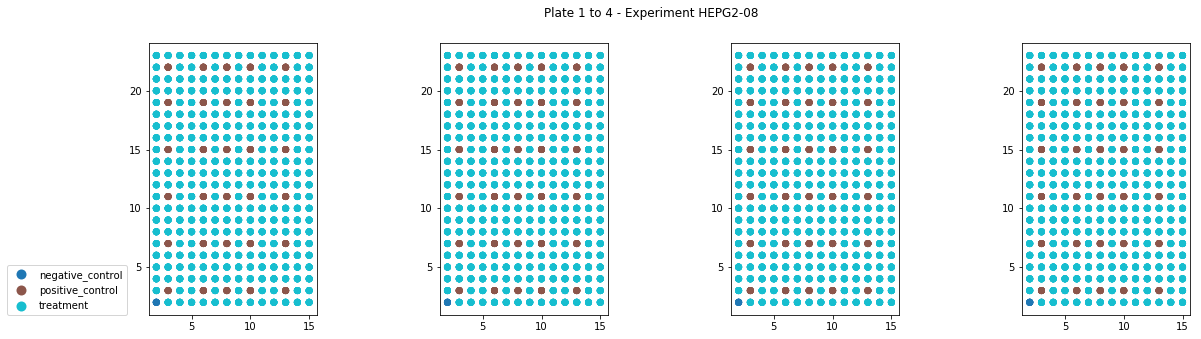

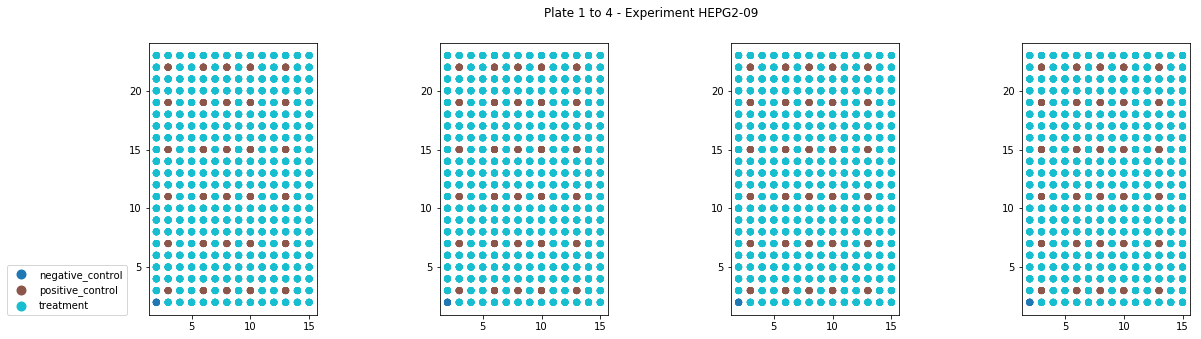

In [33]:
def plot_well_type_positions_for_experiment(experiment_name):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for plate, ax in zip([1,2,3,4], axes):
        one_plate_md = md[md.experiment==experiment_name]
        if plate==1:
            legend=True
        else:
            legend=False
        one_plate_md.plot(column='well_type',legend=legend, ax=ax);
        if plate==1:
            leg = ax.get_legend()
            leg.set_bbox_to_anchor((-0.3, 0., 0.2, 0.2))
    _ = fig.suptitle('Plate 1 to 4 - Experiment {}'.format(experiment_name))

plot_well_type_positions_for_experiment(md.experiment.unique()[0])
plot_well_type_positions_for_experiment(md.experiment.unique()[1])

Each plate holds the same 30 control siRNA conditions (positive controlled - RED), 277 different non-control siRNA (treatment - TURQUOISE), and one untreated well (negative control). The well types follow the same architecture from one plat to another and experiment to another.

### Algorithms and Techniques  

Our solution will use a convolutional neural network architecture, which is the defacto architecture for image classification ([source](https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8)).  
  
To further justify our decision to go along with a CNN architecture, it is to be said ResNet-50 have achieved very good results in multiclass image classification problems in the recent past ([see source](https://arxiv.org/abs/1903.10035)), having reached 98.87% accuracy when classifying histopathology images.  
We will thus use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) with a pretrained ResNet-18 on ImageNet to see if we obtain interesting results, and will use complex versions of it (Resnet-50, Resnet-152 or Densenet(s)) if this is successful.   

To use ResNet-18 properly, we will have to convert its first convolutional layer to support 6 channels instead of 3, and we will modify the final layer to support 1,108 output features (for the 1,108 possible siRNA classes).

### Benchmark
Since our solution uses a convolutional neural network architecture, we thus used a "vanilla" CNN model as our benchmark.  

The base model (see [full base-model notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/basemodel.ipynb)) was a very basic CNN model trained over 2 epochs on 6-channel 512x512 images. Here is the overall architecture:

----------

**Data**:
6-channels images, both sites.
Input resolution: 512x512

**Base model**:
Basic CNN model   

```  
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(6, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (fc1): Linear(in_features=65536, out_features=2216, bias=False)
  (fc2): Linear(in_features=2216, out_features=1108, bias=False)
)   
```   

**Loss**:
Cross Entropy Loss

**Optimizer**:  
Adam w/ lr=0.0003

**Epochs**:
2

**Framework**:
PyTorch

----------

This gave a cross-validation score of 0.0011 (.1% accuracy), and a test score of 0.002 (.2% accuracy). This score is a bit better than chance since we have 1108 classes. An accuracy reflecting chance would be 1/1108, which is equivalent to ~0.09% accuracy.


## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_


## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?